In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import seaborn as sns

from dotenv import load_dotenv
import os

load_dotenv()

API_KEY = os.getenv('BING_API_KEY')

%config InlineBackend.figure_format = 'retina'

plt.rcParams = plt.rcParamsOrig

In [3]:
cities = [
    "Jakarta",
    "Bogor",
    "Bandung",
    "Cikampek",
    "Cirebon",
    "Tasikmalaya",
    "Tegal",
    "Purwokerto",
    "Semarang",
    "Magelang",
    "Yogyakarta",
    "Tulungagung",
    "Kediri",
    "Malang",
    "Surakarta",
    "Surabaya"
]

In [4]:
def get_coordinates(city):
    query = f"{city}, Indonesia"
    url = f"http://dev.virtualearth.net/REST/v1/Locations/{query}?key={API_KEY}"
    resp = requests.get(url)
    data = resp.json()
    obj = data['resourceSets'][0]['resources'][0]
    return obj['name'], obj['point']['coordinates']

def get_distances(locs):
    city_coords = eval(locs.drop('city', axis=1).to_json(orient='records'))
    payload = {
        'origins': city_coords,
        'destinations': city_coords,
        'travelMode': 'driving'
    }
    headers = {
        'Content-Length': '450',
        'Content-Type': 'application/json'
    }
    url = f"https://dev.virtualearth.net/REST/v1/Routes/DistanceMatrix?key={API_KEY}"
    resp = requests.post(url, json=payload, headers=headers)
    return pd.DataFrame(
        resp.json()['resourceSets'][0]['resources'][0]['results']
    )

In [5]:
from tqdm.notebook import tqdm

locations = []
for city in tqdm(cities):
    locations.append(get_coordinates(city))

In [6]:
locs = pd.DataFrame(
    locations,
    columns=['city', 'coordinates']
)
locs = pd.concat([
    locs[['city']],
    locs['coordinates'].apply(
        pd.Series
    ).rename(
        {
            0: 'latitude',
            1: 'longitude'
        },
        axis=1
    )
], axis=1)
locs['city_name'] = locs['city'].apply(lambda x: x.split(',')[0].strip())

In [7]:
distances = get_distances(locs)
distances['source'] = distances['originIndex'].map(locs.city_name.to_dict())
distances['target'] = distances['destinationIndex'].map(locs.city_name.to_dict())
distances['weight'] = distances['travelDistance']

In [8]:
locs.to_csv('../datasets/java-coordinates.csv', index=False)
distances.to_csv('../datasets/java-dist-matrix.csv', index=False)

In [9]:
dist_matrix = distances.pivot_table(
    index='source',
    columns='target',
    values='travelDistance'
)

In [10]:
from sklearn.metrics.pairwise import haversine_distances

results = haversine_distances(
    np.radians(locs[['longitude', 'latitude']])
)
heuristics = pd.DataFrame(
    results * 6371000/1000,  # multiply by Earth radius to get kilometer
    columns=locs.city_name,
    index=locs.city_name
)['Surabaya']

heuristics.sort_index().apply(np.round).astype(int)

city_name
Bandung        570
Bogor          662
Cikampek       589
Cirebon        464
Jakarta        659
Kediri          98
Magelang       281
Malang          33
Purwokerto     389
Semarang       259
Surabaya         0
Surakarta      215
Tasikmalaya    503
Tegal          402
Tulungagung    100
Yogyakarta     266
Name: Surabaya, dtype: int64

In [11]:
edges = {
    "Jakarta": ["Bogor", "Cikampek"],
    "Bogor": ["Bandung"],
    "Bandung": ["Tasikmalaya", "Cirebon"],
    "Cikampek": ["Bandung", "Cirebon"],
    "Cirebon": ["Tegal"],
    "Tasikmalaya": ["Purwokerto"],
    "Tegal": ["Semarang", "Purwokerto"],
    "Purwokerto": ["Magelang", "Yogyakarta"],
    "Semarang": ["Surabaya", "Surakarta"],
    "Magelang": ["Semarang", "Yogyakarta"],
    "Yogyakarta": ["Surakarta", "Tulungagung"],
    "Tulungagung": ["Malang", "Kediri"],
    "Kediri": ["Surabaya"],
    "Malang": ["Surabaya"],
    "Surakarta": ["Surabaya"],
    "Surabaya": []
}

In [12]:
routes = []
for source in edges:
    for target in edges[source]:
        routes.append((source, target))

In [13]:
import networkx as nx

G = nx.from_pandas_edgelist(
    distances.merge(
        pd.DataFrame(
            routes,
            columns=['source', 'target']
        ),
        how='inner',
        on=['source', 'target']
    ),
    edge_attr='weight'
)

In [14]:
pos = locs.set_index('city_name').apply(
    lambda x: (x['longitude'], x['latitude']),
    axis=1
).to_dict()

In [15]:
import geopandas

world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

In [16]:
gdf = geopandas.GeoDataFrame(
    locs,
    geometry=geopandas.points_from_xy(
        locs.longitude,
        locs.latitude)
)

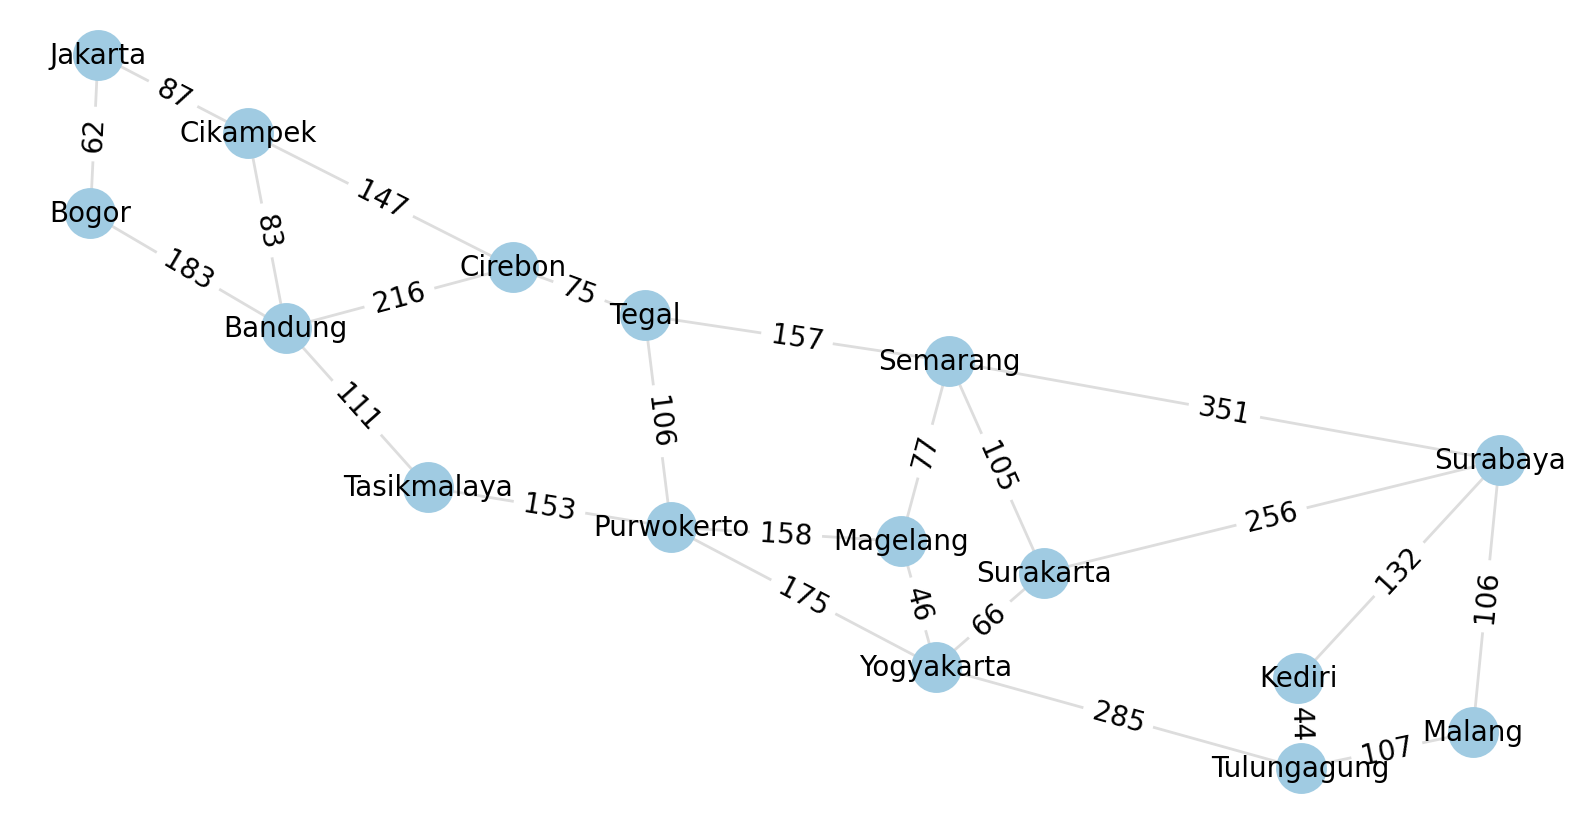

In [23]:
ax = plt.gca()

nx.draw(
    G, pos,
    with_labels=True,
    edge_color='#DDDDDD',
    node_color='#A0CBE2',
    node_size=300,
    font_size=10,
    ax=ax
)

labels = nx.get_edge_attributes(G, 'weight')
labels = {k: np.round(v).astype(int) for k, v in labels.items()}

nx.draw_networkx_edge_labels(
    G, pos,
    edge_labels=labels,
    ax=ax
);

# plt.savefig('../datasets/java.png', bbox_inches='tight', transparent=True, dpi=200)

In [18]:
%load_ext watermark
%watermark --iversions

requests  : 2.23.0
seaborn   : 0.10.0
pandas    : 1.1.2
matplotlib: 3.2.1
geopandas : 0.8.1
networkx  : 2.4
numpy     : 1.19.2

